==============================================================================================
# Practicum 6 - Part 1

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Group A- Group F): December 10th, 23:00 h**

**Deadline (Group B): December 11th, 23:00 h**

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

Today's exercices will practise the following:

- Integral images and a classical use for fast harr-like feature computation.
- Use of Adaboost for classification.
- Decisions based on a user-defined threshold for balancing precision and recall.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
from skimage import io
from time import time

import skimage
from skimage.feature import haar_like_feature
from skimage.transform import resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.model_selection import train_test_split

In [2]:
# Show images
def show_images(m, n, imgs, labels):
    fig, axes = plt.subplots(m, n, figsize=(13, 6))
    ax = axes.ravel()
    cmap='gray'
    for i in range(m*n):
        ax[i].imshow(imgs[i], cmap)
        ax[i].set_title(labels[i])
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

## Haar-like feature descriptor for face detection

### What is a Haar-like feature?

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.png" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.png" width=500, height=500>


A real application would be:

<img src="notebook_images/face.png" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### Face detection

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)


In this work we are going to see:


1. What is a Haar-like feature?
2. Build Integral image
3. Extract Haar features
4. The Adaboost Classifier
5. Face detection with cascade classifier

### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.png" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.png" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**R:** We must have an additonal row and column for the sum of the first pixels cases, and not to have an error. 

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array.

The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

In [3]:
def to_integral_image(img_arr):
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))
    integral_image_arr[1:,1:]= img_arr
    
    for i in range(1, integral_image_arr.shape[0]):
        for j in range(1, integral_image_arr.shape[1]):
            integral_image_arr[i,j] = np.sum(img_arr[:i,:j]) 
    
    return integral_image_arr

**1.2** Construct a binary image of dimensiones 5x5 and visualize it together with its integral image.

In [4]:
img_array = np.random.randint(2, size=(5,5))
ii_img_array = to_integral_image( img_array )

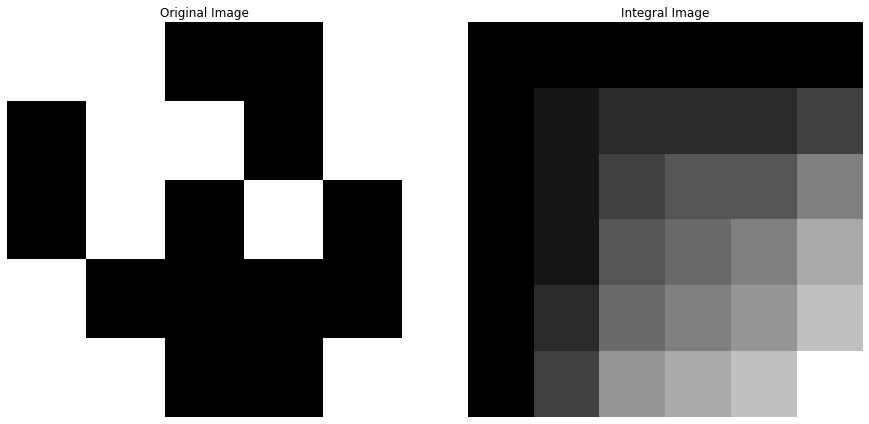

In [5]:
show_images(1, 2, [img_array, ii_img_array], ["Original Image", "Integral Image"])

**1.3** Integral image test

To make sure that the values of the integral image are correct, compute the following tests:

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

In [6]:
np.sum(img_array) == ii_img_array[-1,-1]

True

In [7]:
img_array[0,:].sum() == ii_img_array[1,-1]

True

**1.4** Let's check in real images.

Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

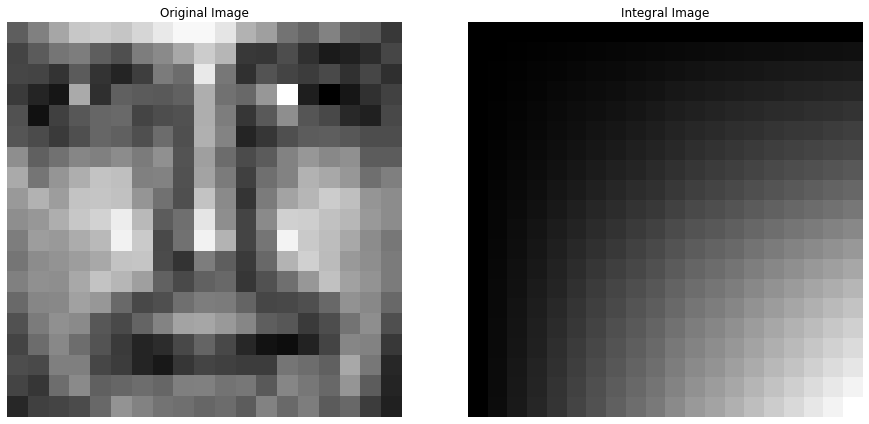

In [8]:
img_ = io.imread('./faces/face00001.png')
integral_ = to_integral_image( img_ )
show_images(1, 2, [img_, integral_], ["Original Image", "Integral Image"])

**1.5** What do the following lines mean? How can you explain this?

 - `sum(img_array) == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`
 - `ii_img_array[0,-1].sum() == 0`
 


**R:** The first one means that the last pixel of the image contains the sum of all the image.
       The second one means that the last position of the first row is the sum of all the elements in its left,
       because in the row above there are only zeros. 
       And the last one, means that the last position of the first row is a zero because all the elements on the first row 
       are zero. 


**1.6: (Optional)** Alternatively to your own function, you can use the function of skimage ``skimage.transform import integral_image``. 

Compare the result obtained using your funtion and that obtained using the function provided by skimage.

In [9]:
from skimage.transform import integral_image
integral_sky = integral_image(img_)
res = integral_[1:,1:] - integral_sky
print(res)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

**R:** We have obteined the same result.

## 2. Haar-like features

Let's use the haar_like_feature function from skimage [Haar like feature](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature)

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*

Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing.

###  Extract features

**2.1** Once we have the function to get the integral image, we can extract the features before building the classifier.

Define a function ``extract_feature_image`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image.


In [10]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [11]:
def extract_feature_image(image, feature_type, feature_coord=None):
    ii = to_integral_image(image)
    features = haar_like_feature(ii, 0, 0, image.shape[0], image.shape[1], feature_type, feature_coord)
    return features

Try your function using the choosing image from *1.4*. 

**Note:** You have to obtain a feature vector. Print the vector shape.

In [12]:
features = extract_feature_image(img_, feature_types)
print("Feature vector:", features)
print("Vector shape: ", features.shape)

Feature vector: [ 0.  0.  0. ... 33. 14.  4.]
Vector shape:  (63666,)


**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- *skimage.feature.haar_like_feature_coord(width, height, feature_type=None)*

- *skimage.feature.draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*


Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``.

In [13]:
def plotFeatures(img, feature_types):
    imgs = []
    
    for i in feature_types:
        feature_coord, _ = skimage.feature.haar_like_feature_coord(img.shape[0], img.shape[1], i)
        image = skimage.feature.draw_haar_like_feature(img, 0, 0, img.shape[0], img.shape[1], feature_coord, 
                                                       max_n_features=1, random_state=0)
        imgs.append(image)
        
    show_images(1, 5, imgs, feature_types)

Try your function using the choosing image from *1.4* as follows:
<img src="notebook_images/image1.png" width=600, height=300>

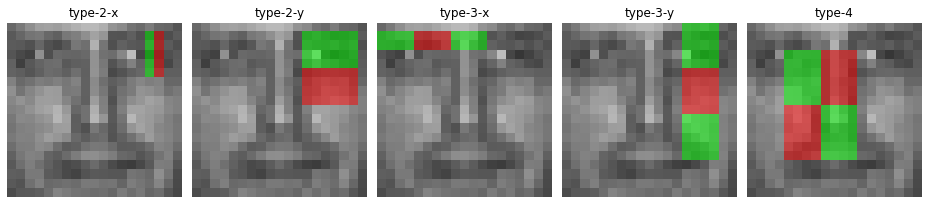

In [14]:
plotFeatures(img_, feature_types)

### 3 Preparing the Dataset

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [15]:
# Build a vector with the faces features
path = "./faces/"                       
face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

features_faces = []

# your solution here
features_faces = [(extract_feature_image(image, feature_types)) for image in face_images]

In [16]:
print(len(features_faces[0]))

63666


In [17]:
# Build a vector with the non-faces features
path = "./nonfaces/"                       
non_face_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

non_features_faces = []

# your solution here
non_features_faces = [(extract_feature_image(image, feature_types)) for image in non_face_images]

In [18]:
X = np.array(features_faces + non_features_faces)
y = np.array(np.concatenate((np.zeros(len(features_faces)), np.ones(len(non_features_faces))))) # Labels face = 1, non face = 0

In [19]:
print(X.shape)
print(y.shape)

(68, 63666)
(68,)


**3.2** Using the function ``train_test_split`` from sklearn, divide the dataset into *train* and *test* set

In [20]:
# Your solution here
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(47, 63666)
(21, 63666)
(47,)
(21,)


### 4  Adaboost training

**4.1** Train an Adaboost classifier using:

*class sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*

What is an Adaboost doing?

In [22]:
from sklearn.ensemble import AdaBoostClassifier
# Your solution here
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
clf.fit(X_train, y_train)

AdaBoostClassifier()

**4.2** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [23]:
# Your solution here
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Result: ", result)
print("Accuracy: ", acc)

Result:  [0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Accuracy:  0.9047619047619048


**R:** Mirar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [24]:
# Your solution here
clf = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
clf.fit(X_train, y_train)

# Your solution here
result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Result: ", result)
print("Accuracy: ", acc)

Result:  [0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
Accuracy:  0.9523809523809523


**R:** Yes, the accuracy hasn't improved.

**4.3** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

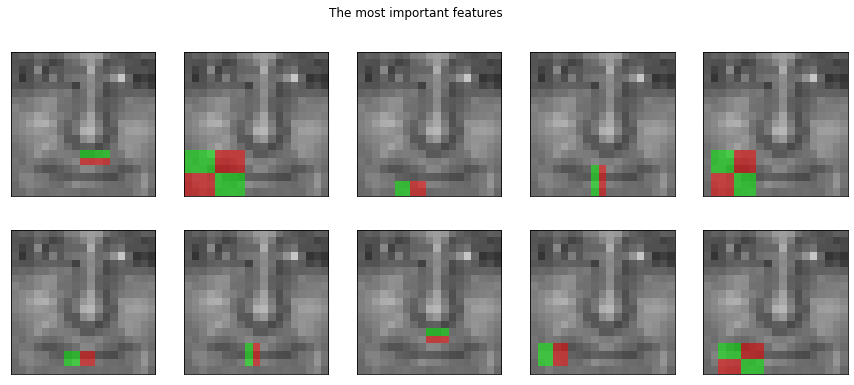

In [25]:
# Your solution here
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(2, 5, figsize=(15,6))
img = io.imread('./faces/face00001.png')
feature_coord, _ = skimage.feature.haar_like_feature_coord(img.shape[0], img.shape[1], feature_types)

for idx, ax in enumerate(axes.ravel()):
    img = face_images[0]
    image = draw_haar_like_feature(img, 0, 0,
                                   img.shape[0],
                                   img.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

**4.4**  Try the Adabost classifier using other faces and non-faces images. What is the result? 

In [30]:
def load_resize(path):
    collection = os.listdir(path)
    imgs = []
    for file in collection:
        img = io.imread(path + file)
        img = rgb2gray(img)
        img = resize(img, (19,19))
        imgs.append(img)
        
    return imgs

In [34]:
# Your solution heref
# Build a vector with the faces features
path = "./another_faces/"  
face_images = load_resize(path)
features_faces = [(extract_feature_image(image, feature_types)) for image in face_images]

In [35]:
X = np.array(features_faces + non_features_faces)
y = np.array(np.concatenate((np.zeros(len(features_faces)), np.ones(len(non_features_faces))))) # Labels face = 1, non face = 0

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

In [37]:
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)
clf.fit(X_train, y_train)

result = clf.predict(X_test)
acc = clf.score(X_test, y_test)
print("Result: ", result)
print("Accuracy: ", acc)

Result:  [1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
Accuracy:  0.9166666666666666


**4.5 (Optional)** Implement the Adaboost training the model with just 1 type of feature. And 2 types? And 3 types? Plot the results comparing the precision. Draw conclusions about the results

In [ ]:
# Your solution here

### 5. Cascade of classifiers

The Cascade Adaboost is implemented in the class ``skimage.feature.Cascade``.

**5.1** Compare the performance of the Cascade classifier  and your Adaboost classifier from point 4 on the folder *another_faces*. Show the detected faces by both classifiers and compare their score.

<img src="notebook_images/cascade.png" width=300, height=300>


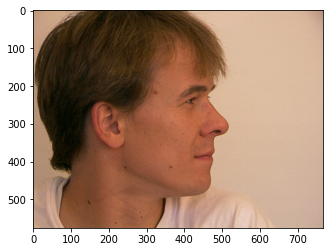

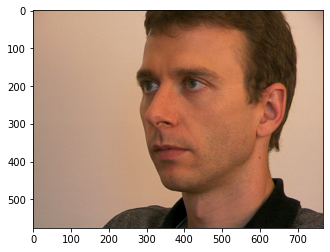

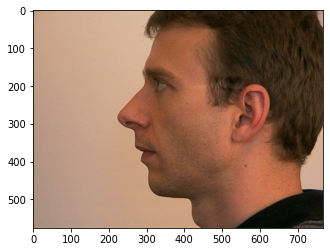

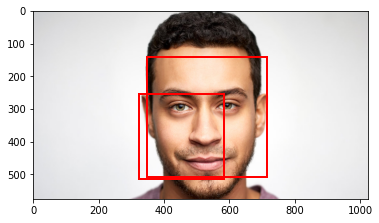

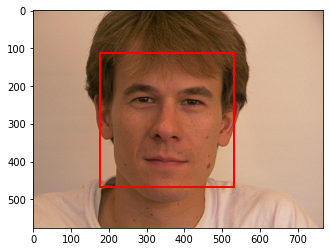

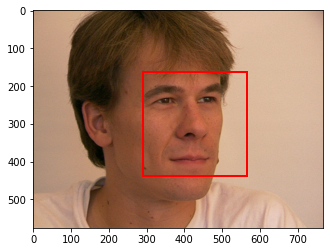

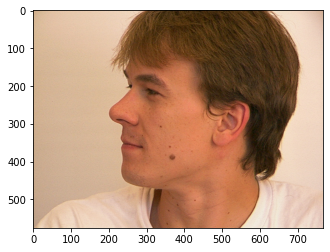

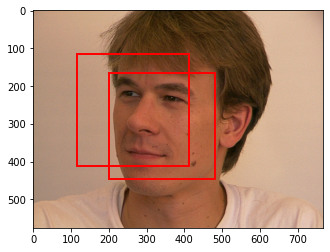

In [53]:
from skimage.feature import Cascade
from skimage import data
from matplotlib import patches

# Load face images
path = "./another_faces/"                       
original_another_faces = [skimage.io.imread(path + f) for f in os.listdir(path)]

# Load the Cascade trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the dectector cascade
for query in original_another_faces:
    detector = Cascade(trained_file)
    detected = detector.detect_multi_scale(img=query, scale_factor=1.2, step_ratio=1, min_size=(50, 50),
                                           max_size=(500, 500))

    plt.imshow(query)
    img_desc = plt.gca()
    plt.set_cmap('gray')

    for patch in detected:

        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,
                color='r',
                linewidth=2
            )
        )

    plt.show()